In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# CIFAR10 datasets를 통해서 해당 데이터를 분류하는 모델을 만든다.

In [2]:
%config Completer.use_jedi = False

In [3]:
# cifar10 dataset을 통해 classification model을 만든다.

from tensorflow.keras.datasets import cifar10

(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
print(train_images.shape)
print(train_labels.shape)

2024-02-09 08:07:10.095239: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-09 08:07:10.095350: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-09 08:07:10.264787: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


170498071/170498071 [==============================] - 2s 0us/step
(50000, 32, 32, 3)
(50000, 1)


In [4]:
# 첫번째 이미지에 대한 정보 확인

print(train_images[0,:,:])
print(train_labels[0,:])

[[[ 59  62  63]
  [ 43  46  45]
  [ 50  48  43]
  ...
  [158 132 108]
  [152 125 102]
  [148 124 103]]

 [[ 16  20  20]
  [  0   0   0]
  [ 18   8   0]
  ...
  [123  88  55]
  [119  83  50]
  [122  87  57]]

 [[ 25  24  21]
  [ 16   7   0]
  [ 49  27   8]
  ...
  [118  84  50]
  [120  84  50]
  [109  73  42]]

 ...

 [[208 170  96]
  [201 153  34]
  [198 161  26]
  ...
  [160 133  70]
  [ 56  31   7]
  [ 53  34  20]]

 [[180 139  96]
  [173 123  42]
  [186 144  30]
  ...
  [184 148  94]
  [ 97  62  34]
  [ 83  53  34]]

 [[177 144 116]
  [168 129  94]
  [179 142  87]
  ...
  [216 184 140]
  [151 118  84]
  [123  92  72]]]
[6]


In [5]:
# train_labels 10개 출력
NAMES = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
# print(train_labels[:10])

for i in range(10):
    print(train_labels[i])
    print(NAMES[train_labels[i,0]])

[6]
frog
[9]
truck
[9]
truck
[4]
deer
[1]
automobile
[1]
automobile
[2]
bird
[7]
horse
[8]
ship
[3]
cat


### CIFAR10 데이터 시각화
* 이미지 크기는 32*32이며, RGB채널, 수식으로 표현하면 32*32*3
* 이미지를 보면 전반적으로 label에 해당하는 대상이 가운데에 있고, 그 이미지에서 label 대상의 비중이 크다

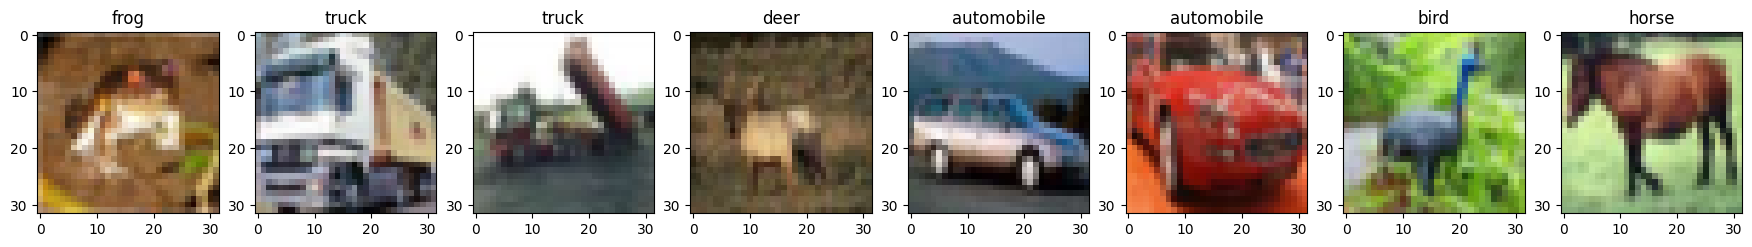

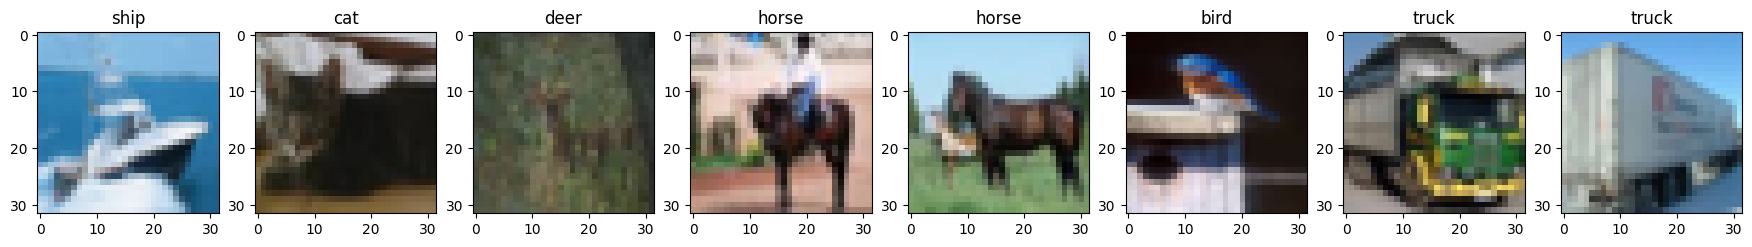

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_images(images, labels, ncols=8):
    figure, axs = plt.subplots(figsize=(22,6), nrows=1, ncols=ncols)
    for i in range(ncols):
        axs[i].imshow(images[i])
        label = labels[i].squeeze()  # 원래 labels가 2차원 데이터로 들어오는데 이걸 1차원으로 축소
        axs[i].set_title(NAMES[int(label)])

show_images(train_images[:8], train_labels[:8], ncols=8)
show_images(train_images[8:16], train_labels[8:16], ncols=8)

### data preprocessing
* iamge array의 0 ~ 255 사이의 값으로 되어 있는 pixel intensity 값을 0 ~ 1 사이 값으로 변환. 각 pixel을 255.0으로 나눈다.
* label array는 숫자형 값으로 바꾸고 이후 one hot encoding을 적용할지 선택한다. 이번 모델은 one hot encoding을 적용하지 않는다.
* image array, label array 모두 np.float32로 형변환. np.float32는 tensor 변환시 tf.float32로 변환되어 기본적으로 tensorflow backend keras는 tf.float32를 기반으로 한다.

In [7]:
# label은 one hot encoding이 keras에서 활용이 용이하나 이번에는 sparse categorical crossentropy를 사용해보기 위해 적용하지 않는다.

def get_preprocessed_data(images, labels):
    
    # 학습과 테스트 이미지 array를 0 ~ 1 사잇값으로 scale 및 float32로 변환
    images = np.array(images/255.0, dtype=np.float32)
    labels = np.array(labels, dtype=np.float32)
    
    return images, labels

train_images, train_labels = get_preprocessed_data(train_images, train_labels)
test_images, test_labels = get_preprocessed_data(test_images, test_labels)

In [8]:
# 전처리 적용 여부 확인
train_images[0]

array([[[0.23137255, 0.24313726, 0.24705882],
        [0.16862746, 0.18039216, 0.1764706 ],
        [0.19607843, 0.1882353 , 0.16862746],
        ...,
        [0.61960787, 0.5176471 , 0.42352942],
        [0.59607846, 0.49019608, 0.4       ],
        [0.5803922 , 0.4862745 , 0.40392157]],

       [[0.0627451 , 0.07843138, 0.07843138],
        [0.        , 0.        , 0.        ],
        [0.07058824, 0.03137255, 0.        ],
        ...,
        [0.48235294, 0.34509805, 0.21568628],
        [0.46666667, 0.3254902 , 0.19607843],
        [0.47843137, 0.34117648, 0.22352941]],

       [[0.09803922, 0.09411765, 0.08235294],
        [0.0627451 , 0.02745098, 0.        ],
        [0.19215687, 0.10588235, 0.03137255],
        ...,
        [0.4627451 , 0.32941177, 0.19607843],
        [0.47058824, 0.32941177, 0.19607843],
        [0.42745098, 0.28627452, 0.16470589]],

       ...,

       [[0.8156863 , 0.6666667 , 0.3764706 ],
        [0.7882353 , 0.6       , 0.13333334],
        [0.7764706 , 0

In [9]:
# keras는 CNN 2D 모델에 학습 데잍터 입력 시 반드시 image array는 4차원 배열이 되어야 한다.
# rgb 채널 이미지 array는 기본적으로 3차원인데 여기서 이미지의 개수를 포함해서 4차원이 형성되는 구조다.
# 만일 grayscale이 2차원 이미지 array라고 해도 의도적으로 채널을 명시해서 3차원으로 만들어 이미지 개수를 포함하면 4차원이 되도록 해야한다.

print(train_images.shape, train_labels.shape)

(50000, 32, 32, 3) (50000, 1)


In [10]:
# labels 데이터가 2차원임. 이를 keras 모델에 입력해도 문제없이 작동한다.
# 그치만 one hot encoding의 적용 여부를 명확하게 알 수 있게 1차원으로 만들어주자

train_labels = train_labels.squeeze()
test_labels = test_labels.squeeze()

print(train_labels.shape)
print(test_labels.shape)

(50000,)
(10000,)


### Model 생성
* CNN Model의 첫 layer에는 input_layer을 넣고 shape는 이미지 사이즈에 맞게 설정
* conv 연산을 적용하고 maxpooling을 적용. maxpooling 적용 후에는 필터 개수를 증가시킴
* maxpooling 이후 feature map 사이즈는 작아지지만 채널(깊이)은 늘어나는 형태.
* CIFAR10의 Label수가 10개이므로 Classification을 위한 맨 마지막 Dense layer의 units 갯수는 10개임
* label값이 원-핫 인코딩 되지 않았기 때문에 model.compile()에서 loss는 반드시 sparse_categorical_crossentropy여야함.

In [11]:
IMAGE_SIZE = 32

In [12]:
# 이미지 자체 사이즈가 3*3으로 크지 않아서 kernel_size를 지나치게 크게 잡을 필요가 없다.
# 초기 receptive_field 크기 설정에 대해서 정해진 법칙은 없고 돌려보면서 확인해야 한다.

from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, Activation, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

x = Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(input_tensor)
x = Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(x)
x = MaxPooling2D(2)(x)

x = Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
x = Conv2D(filters=64, kernel_size=3, padding='same')(x)
x = Activation('relu')(x)  # 이런식으로 conv2d와 activation을 별개로 적용할 수 있다.
x = MaxPooling2D(2)(x)

x = Conv2D(filters=128, kernel_size=3, padding='same', activation='relu')(x)
x = Conv2D(filters=128, kernel_size=3, padding='same', activation='relu')(x)
x = MaxPooling2D(2)(x)

# cifar의 클라스가 10개니까 마지막 layer의 unit 개수는 10개
x = Flatten()(x)
x = Dropout(rate=0.5)(x)
x = Dense(300, activation='relu')(x)
x = Dropout(rate=0.3)(x)
output = Dense(10, activation='softmax')(x)

model = Model(inputs=input_tensor, outputs=output)

model.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        36928     
                                                             

In [13]:
# optimizer는 Adam으로 설정하고 label 값이 one hot encoding이 아니니까 loss는 sparse cateorical crossentropy
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

## Model 학습 수행 및 테스트 데이터로 평가
* Model의 fit 메소드를 호출해 학습
* fit은 학습 데이터가 np array 형태로 들어올 때랑 Generator 형태로 들어올 때 약간의 차이가 있음
* batch_size는 한번에 가져올 image label array 개수. 수가 너무 작으면 시간이 오래 걸리고 너무 크면 gpu memory 부족이 발생할 수 있어 적절한 batch size 설정이 필요. 단, 학습 데이터가 generator인 경우 

In [14]:
model_fit = model.fit(x=train_images, y = train_labels, batch_size=64, epochs=30, validation_split=0.15)

Epoch 1/30


I0000 00:00:1707466057.416307      74 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


665/665 [==============================] - 13s 9ms/step - loss: 1.6509 - accuracy: 0.3901 - val_loss: 1.3944 - val_accuracy: 0.5109
Epoch 2/30
665/665 [==============================] - 5s 7ms/step - loss: 1.2026 - accuracy: 0.5679 - val_loss: 1.0248 - val_accuracy: 0.6392
Epoch 3/30
665/665 [==============================] - 5s 7ms/step - loss: 0.9925 - accuracy: 0.6496 - val_loss: 0.9377 - val_accuracy: 0.6645
Epoch 4/30
665/665 [==============================] - 5s 7ms/step - loss: 0.8658 - accuracy: 0.6962 - val_loss: 0.7883 - val_accuracy: 0.7144
Epoch 5/30
665/665 [==============================] - 5s 7ms/step - loss: 0.7699 - accuracy: 0.7282 - val_loss: 0.7377 - val_accuracy: 0.7449
Epoch 6/30
665/665 [==============================] - 5s 7ms/step - loss: 0.6985 - accuracy: 0.7569 - val_loss: 0.7357 - val_accuracy: 0.7423
Epoch 7/30
665/665 [==============================] - 5s 7ms/step - loss: 0.6457 - accuracy: 0.7733 - val_loss: 0.6602 - val_accuracy: 0.7711
Epoch 8/30
665/6

In [15]:
model_fit.history

{'loss': [1.6508715152740479,
  1.2026289701461792,
  0.9924956560134888,
  0.8658387064933777,
  0.7699223756790161,
  0.6985228657722473,
  0.6456977725028992,
  0.5959919095039368,
  0.5593820214271545,
  0.5168556571006775,
  0.493472695350647,
  0.45461276173591614,
  0.44215628504753113,
  0.4106155335903168,
  0.4019975960254669,
  0.37746357917785645,
  0.3582691550254822,
  0.3483109176158905,
  0.332544207572937,
  0.32876765727996826,
  0.3151107430458069,
  0.31201788783073425,
  0.30016258358955383,
  0.2996378540992737,
  0.29078251123428345,
  0.28266528248786926,
  0.2845502495765686,
  0.26485952734947205,
  0.2685440480709076,
  0.2592918872833252],
 'accuracy': [0.39014118909835815,
  0.5678823590278625,
  0.6496235132217407,
  0.6961647272109985,
  0.7282117605209351,
  0.7569411993026733,
  0.7733176350593567,
  0.7898823618888855,
  0.8047764897346497,
  0.8202823400497437,
  0.827505886554718,
  0.8396941423416138,
  0.842941164970398,
  0.8537647128105164,
  0.8

313/313 [==============================] - 1s 3ms/step - loss: 0.7156 - accuracy: 0.8025


[0.7155719995498657, 0.8025000095367432]

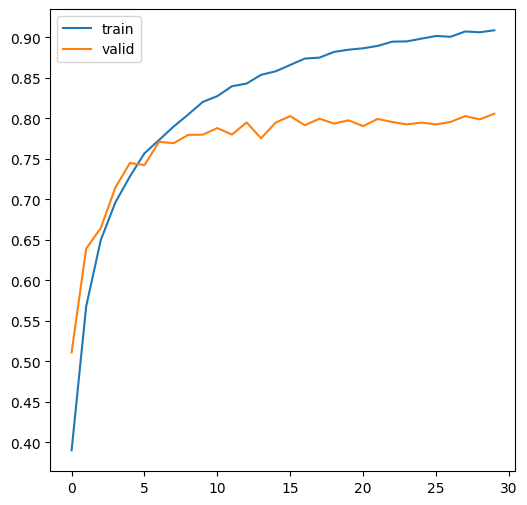

In [16]:
# 결과를 보면 알겠지만 오버피팅의 경향을 보이고 있음

import matplotlib.pyplot as plt
%matplotlib inline

def show_history(history):
    plt.figure(figsize=(6,6))
    plt.yticks(np.arange(0,1, 0.05))
    plt.plot(model_fit.history['accuracy'], label='train')
    plt.plot(model_fit.history['val_accuracy'], label='valid')
    plt.legend()
    
show_history(model_fit)

model.evaluate(test_images, test_labels)

### model.predict()를 통해 이미지 분류 예측
* 4차원 이미지 배열을 입력해서 모델학습을 하는 경우, predict시에도 4차원 이미지 배열을 입력해야 한다.
* 학습 데이터의 원-핫 인코딩 적용 여부와 관계없이 softmax 적용 결과는 무조건 2차원이 나오므로 이에 유의하자.

In [17]:
# 아래 코드는 Conv2D를 사용한 모델에 4차원 이미지 배열을 입력해야 하는데 3차원 이미지 배열을 넣어서 오류 발생
# 개별 이미지를 사용하는 경우 3차원 데이터가 model에 입력되므로 오류 발생

test_images[0].shape  # 3차원 배열

# preds = model.predict(test_images[0])

(32, 32, 3)

In [18]:
# 테스트용 4차원 이미지 배열을 입력해서 predict 수행
# predict의 결과는 softmax 적용 결과다 
# 이는 학습 데이터의 원-핫 인코딩 적용 여부와 관계없이 softmax 적용 결과는 무조건 2차원이다.

preds = model.predict(np.expand_dims(test_images[0], axis=0))
print('예측 결과 shape', preds.shape)
print('예측 결과', preds)

1/1 [==============================] - 1s 520ms/step
예측 결과 shape (1, 10)
예측 결과 [[1.9199882e-07 1.1784901e-11 8.6426667e-08 9.6478248e-01 2.0174998e-06
  3.5202004e-02 1.2831308e-05 3.6011969e-07 3.4032552e-09 3.3302686e-10]]


In [19]:
print(test_images[:16].shape) # (16, 32, 32, 3)

preds = model.predict(test_images[:32], batch_size=32)
print(preds.shape)
print(preds)

(16, 32, 32, 3)
1/1 [==============================] - 0s 18ms/step
(32, 10)
[[1.91991731e-07 1.17845239e-11 8.64252101e-08 9.64782834e-01
  2.01746207e-06 3.52016166e-02 1.28310921e-05 3.60113290e-07
  3.40313955e-09 3.33012368e-10]
 [9.97709719e-08 7.13531685e-04 4.63729991e-17 1.29446031e-12
  1.33153569e-18 2.27228155e-16 4.31997052e-15 3.14557529e-20
  9.99286354e-01 3.82023346e-09]
 [1.55922975e-02 1.24851437e-02 6.08549826e-03 1.68960001e-02
  9.48201772e-03 3.09785688e-03 2.21043010e-03 6.66715950e-03
  9.23578322e-01 3.90519970e-03]
 [6.44109845e-01 5.67907374e-03 3.73397634e-05 1.60498108e-04
  1.02864171e-04 1.34654283e-06 2.02430840e-07 1.32616819e-07
  3.36350381e-01 1.35582425e-02]
 [2.16554760e-11 5.17200931e-08 2.77637527e-03 2.28199866e-02
  1.06996798e-03 1.22900644e-07 9.73333418e-01 6.25054097e-09
  5.40937162e-09 1.71273065e-10]
 [8.56232511e-13 1.55543312e-09 3.74607282e-07 7.70508486e-04
  6.27897680e-06 1.11131184e-02 9.88109708e-01 4.14942747e-09
  2.30833630e-

In [20]:
predicted_class = np.argmax(preds, axis=1)
print('예측 클래스 값',predicted_class)

예측 클래스 값 [3 8 8 0 6 6 5 6 3 1 0 9 5 7 9 8 5 7 8 6 9 0 4 9 4 2 2 0 9 6 6 5]


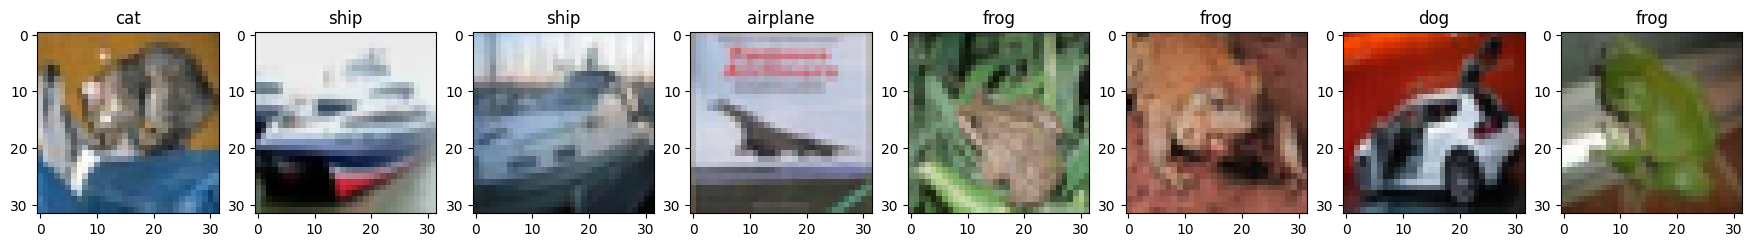

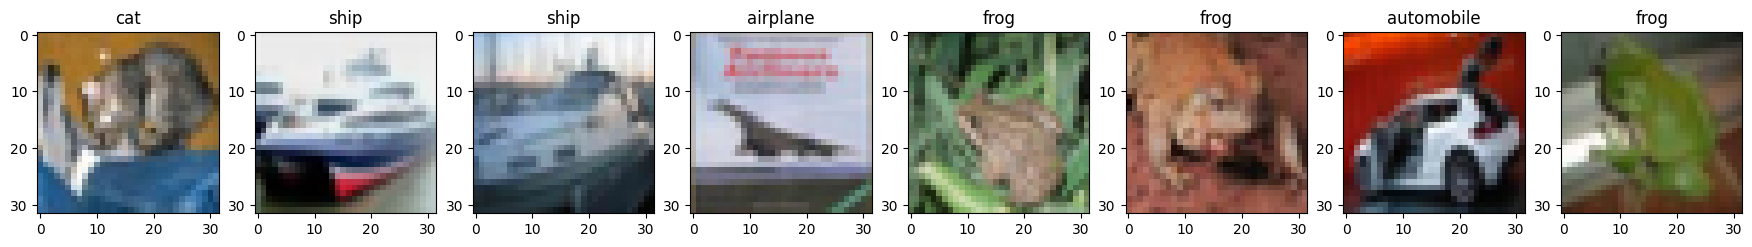

In [21]:
show_images(test_images[:8], predicted_class[:8], ncols=8)
show_images(test_images[:8], test_labels[:8], ncols=8)